In [35]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [36]:
RS = 42

## Random Forest

Выяснили:
1. Отношение сплита тренировочных данных особо на результат не влияет, то есть неравномерности в выборке нет.
2. Удаление коррелирующих параметров сильно на результат не влияет, только на скорость обучения. Разве что если удалить много параметров, показатели сильно ухудшаются.
3. Андерсэмплинг датасета чуть лучше чем балансировка весов, но с балансировкой есть возможность увеличить recall.

### 1. Разбиение данных

In [37]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 3:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

splits = [train_test_split(features, labels, random_state=RS, train_size=0.8),
          train_test_split(features, labels, random_state=RS, train_size=0.7),
          train_test_split(features, labels, random_state=RS, train_size=0.8, stratify=labels),
          train_test_split(features, labels, random_state=RS, train_size=0.7, stratify=labels)]

for sp in splits:
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  metrics(clf.predict(sp[1]), sp[3])

Accuracy:   0.9364468723551589
Precision:  0.8775790921595599
Recall:     0.464
F1:         0.6070409134157945
[[11533    89]
 [  737   638]]
Accuracy:   0.9393208863356586
Precision:  0.8866171003717472
Recall:     0.47344913151364765
F1:         0.617275962471692
[[17359   122]
 [ 1061   954]]
Accuracy:   0.9432946064476417
Precision:  0.8940217391304348
Recall:     0.4996203492786636
F1:         0.6410131514856308
[[11602    78]
 [  659   658]]
Accuracy:   0.9406032006565449
Precision:  0.8828491096532334
Recall:     0.4769620253164557
F1:         0.6193293885601578
[[17396   125]
 [ 1033   942]]


**Recall** показывает насколько много в определенных как переменные переменных.

**Precision** показывает насколько много переменных звезд мы не упустили.

### 2. Коррелирующие параметры

<Axes: >

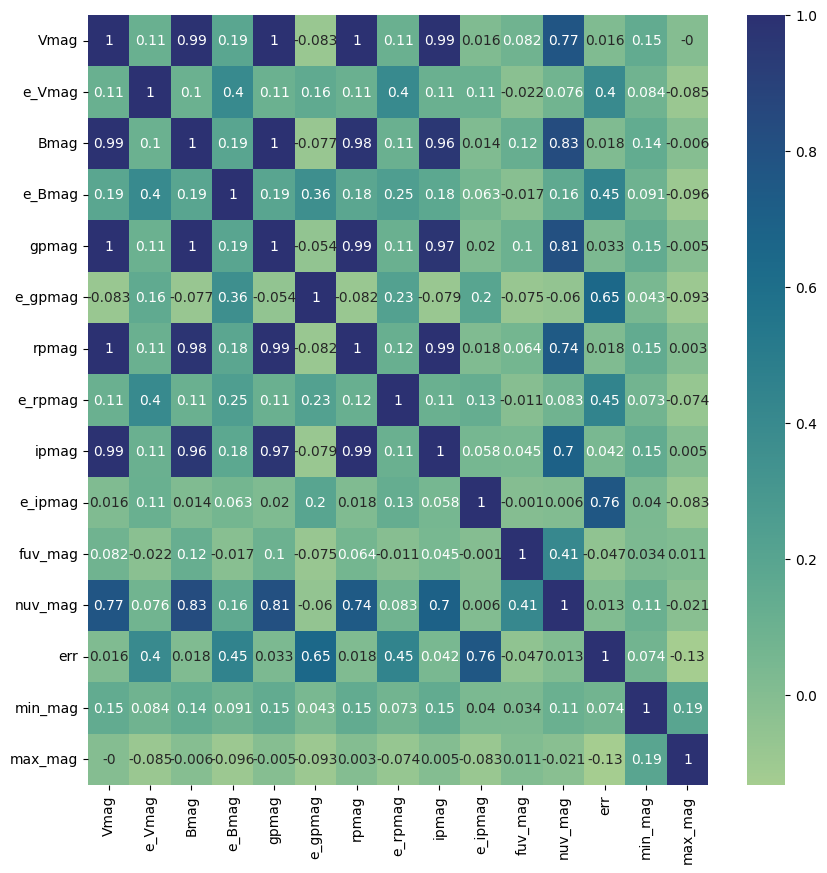

In [38]:
plt.figure(figsize=(10, 10))

corr = features.corr()
sns.heatmap(corr.round(3), cmap="crest", annot=True)

In [39]:
candidates = []  # видно, что связаны одни и те же, поэтому одномерного списка достаточно
treshold = 0.8
for row in corr.iterrows():
  for col in row[1].items():
    if row[0] != col[0] and col[1] > treshold and col[0] not in candidates:
      candidates.append(col[0])

candidates

['Bmag', 'gpmag', 'rpmag', 'ipmag', 'Vmag', 'nuv_mag']

In [40]:
features_copy = features.copy()
# хотя бы один из связанных должен остаться
draw_data = []
for c in candidates[:-1]:
  features_copy.drop(c, inplace=True, axis=1)
  sp = train_test_split(features_copy, labels, random_state=RS, train_size=0.8)
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  draw_data.append(metrics(clf.predict(sp[1]), sp[3]))
  draw_data[-1]["Deleted"] = c

# sns.relplot(draw_data)
# можно понять, что nuv_magnitude is important

Accuracy:   0.9369085173501577
Precision:  0.8958630527817404
Recall:     0.4567272727272727
F1:         0.605009633911368
[[11549    73]
 [  747   628]]
Accuracy:   0.9359082865276602
Precision:  0.8961988304093568
Recall:     0.44581818181818184
F1:         0.5954346770276834
[[11551    71]
 [  762   613]]
Accuracy:   0.9327537123951681
Precision:  0.8836140888208269
Recall:     0.41963636363636364
F1:         0.5690335305719921
[[11546    76]
 [  798   577]]
Accuracy:   0.9254443333076864
Precision:  0.8717948717948718
Recall:     0.3461818181818182
F1:         0.49557522123893805
[[11552    70]
 [  899   476]]
Accuracy:   0.9092867584827268
Precision:  0.8161290322580645
Recall:     0.184
F1:         0.3002967359050445
[[11565    57]
 [ 1122   253]]


<Axes: xlabel='Deleted'>

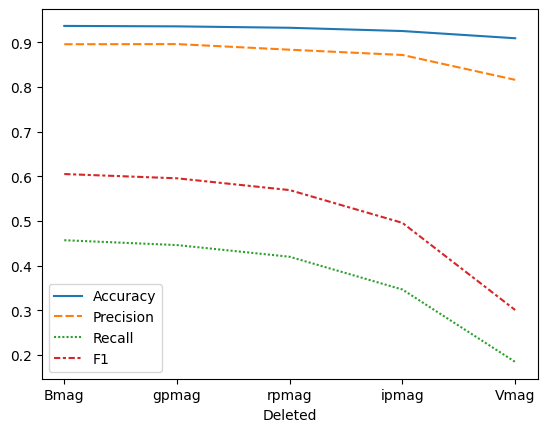

In [41]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Deleted"])
sns.lineplot(draw_df)

### 3. Undersmapling vs balanced

In [42]:
X, x, Y, y = train_test_split(features, labels, random_state=RS, train_size=0.8)

classes = Y.unique()
weights = [compute_class_weight('balanced', classes=classes, y=Y)]
weights

[array([0.55567788, 4.99011327])]

In [43]:
weights += [[1, 20], [1, 30], [1, 60]]

# в декоратор бы это все)
draw_data = []
for w in weights:
  clf = RandomForestClassifier(class_weight=dict(zip(classes, w)), n_jobs=-1)
  clf.fit(X, Y)
  print(f"With weight {w}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Weights"] = round(w[1] / w[0], 2)

With weight [0.55567788 4.99011327]
Accuracy:   0.9359082865276602
Precision:  0.9093655589123867
Recall:     0.43781818181818183
F1:         0.5910652920962199
[[11562    60]
 [  773   602]]
With weight [1, 20]
Accuracy:   0.9354466415326614
Precision:  0.8952802359882006
Recall:     0.44145454545454543
F1:         0.5913297613248905
[[11551    71]
 [  768   607]]
With weight [1, 30]
Accuracy:   0.9343694698776641
Precision:  0.910377358490566
Recall:     0.42109090909090907
F1:         0.5758329189457981
[[11565    57]
 [  796   579]]
With weight [1, 60]
Accuracy:   0.9332153573901669
Precision:  0.8967136150234741
Recall:     0.4167272727272727
F1:         0.5690168818272096
[[11556    66]
 [  802   573]]


Видно, что веса особо эффекта не приносят

<Axes: xlabel='Weights'>

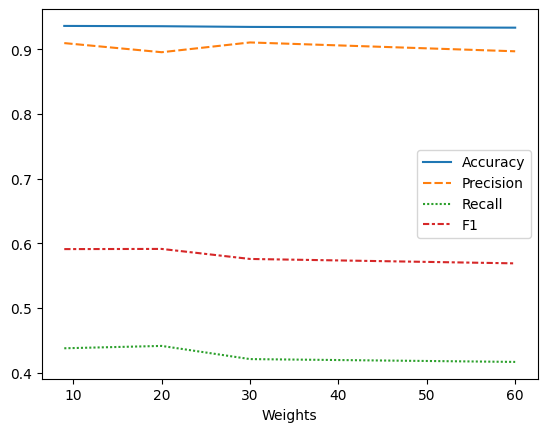

In [44]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Weights"])
sns.lineplot(draw_df)

Try different split ratios for undersampling training

In [45]:
N = Y[Y == 1].size  # number of variable stars
new_train = pd.concat([X, Y], axis=1)

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])
  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(X, Y)
  print(f"Undersmapling with ratio 1/{r}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Ratio"] = r

Undersmapling with ratio 1/1
Accuracy:   0.8732784488728168
Precision:  0.4529737206085754
Recall:     0.9527272727272728
F1:         0.6140145301148348
[[10040  1582]
 [   65  1310]]
Undersmapling with ratio 1/2
Accuracy:   0.9254443333076864
Precision:  0.602112676056338
Recall:     0.8705454545454545
F1:         0.711864406779661
[[10831   791]
 [  178  1197]]
Undersmapling with ratio 1/3
Accuracy:   0.942371316457644
Precision:  0.7029831387808041
Recall:     0.7883636363636364
F1:         0.7432293452176894
[[11164   458]
 [  291  1084]]
Undersmapling with ratio 1/4
Accuracy:   0.9432946064476417
Precision:  0.752373417721519
Recall:     0.6916363636363636
F1:         0.7207275483137552
[[11309   313]
 [  424   951]]


<Axes: xlabel='Ratio'>

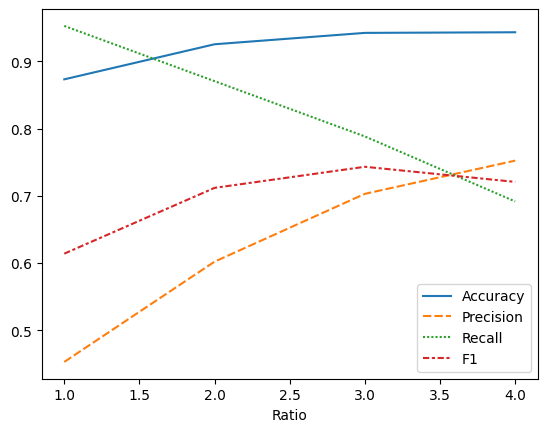

In [46]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Ratio"])
sns.lineplot(draw_df)

### Hyperparameter tuning

Будем тренировать не с балансировкой, а с меньшим датасетом, так как он показывает результаты получше. Ну может это и странно, что я опираюсь на результаты для теста, надо потом проверить с другим рандомным состоянием.

Балансировку выберем не 1/1, опять же по тесту, видимо есть золотая середина между размером выборки и ее сбалансированностью.

In [47]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                     new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [48]:
params = {
  "n_estimators": [100, 300, 500],
  "max_depth": [8, 16, 32],  # FIXME: maybe too deep??
  # "min_samples_leaf" minimum samples from dataset for a node
  # "min_samples_split": [],  let's say we don't need simple trees, but overfitting?
  "n_jobs": [-1]
}

clf = GridSearchCV(RandomForestClassifier(), params)
clf.fit(X, Y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 16, 32],
                         'n_estimators': [100, 300, 500], 'n_jobs': [-1]})

Этот результат более надежный, так как модели при тренировке проходили кросс-валидацию, значит мы, условно, не подбирали параметры по тестовой выборке.

Но можно заметить, что параметры особо не влияют на результат.

In [49]:
metrics(clf.best_estimator_.predict(x), y, to_return=False)

Accuracy:   0.9418327306301454
Precision:  0.6965079365079365
Recall:     0.7978181818181819
F1:         0.7437288135593221
[[11144   478]
 [  278  1097]]


### Combine high recall and high precision

In [50]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                   new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [51]:
params = {
    "n_estimators": [200],
    "class_weight": [{1: 10}, {1: 20}, {1: 40}],  # high penalty for false positive
    "max_depth": [8, 16],
}
rf_precision = GridSearchCV(RandomForestClassifier(
), params, scoring='precision', n_jobs=-1).fit(X, Y).best_estimator_
rf_precision

RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)

In [52]:
metrics(rf_precision.predict(x), y, to_return=False)

Accuracy:   0.8652766022928368
Precision:  0.43543956043956045
Recall:     0.9221818181818182
F1:         0.5915558665733613
[[9978 1644]
 [ 107 1268]]


In [53]:
params = {
    "n_estimators": [200],
    "class_weight": [{0: 10}, {0: 20}, {0: 40}],  # high penalty for FN
    "max_depth": [8, 16]
}
rf_recall = GridSearchCV(RandomForestClassifier(
), params, scoring='recall', n_jobs=-1).fit(X, Y).best_estimator_
rf_recall

RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200)

In [54]:
metrics(rf_recall.predict(x), y, to_return=False)

Accuracy:   0.9205201200276987
Precision:  0.7408450704225352
Recall:     0.3825454545454545
F1:         0.5045563549160671
[[11438   184]
 [  849   526]]


In [55]:
ensemble = VotingClassifier(
    estimators=[
        ('precision_model', RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)),
        ('recall_model', RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200))
    ],
    voting='hard'  # just majority vote
)

ensemble.fit(X, Y)

VotingClassifier(estimators=[('precision_model',
                              RandomForestClassifier(class_weight={1: 10},
                                                     max_depth=16,
                                                     n_estimators=200)),
                             ('recall_model',
                              RandomForestClassifier(class_weight={0: 10},
                                                     max_depth=16,
                                                     n_estimators=200))])

In [56]:
metrics(ensemble.predict(x), y, to_return=False)

Accuracy:   0.921212587520197
Precision:  0.772093023255814
Recall:     0.36218181818181816
F1:         0.49306930693069306
[[11475   147]
 [  877   498]]
